# Some preprocessing of IABP data

In this Jupyter notebook we select for 13 10-day-long periods the IABP buoys we keep for our study. We select the buoys available for each period and check their trajectory. We only keep trajectories with enough data on the period (more details below) and without obvious non-physical trajectories. At the end, we create .dat files that we could use with sitrack for the seeding of the buoys, and one NetCDF file per period only containing the buoys of interest for this period.

N.B. In the end, in Fiol et al. 2026, only the periods covering the winter are considered (the first eight periods). 

In [1]:
#Loading of the libraries useful in the following

##computing
import numpy as np
import xarray as xr

##graphical display
import matplotlib.pyplot as plt

    ###projection
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

##Saving of files
    
    ##.dat files
import csv

    ##For saving into an NetCDF file
from sitrack import ncio

In the Jupyter notebook, we use a function of sitrack (https://github.com/brodeau/sitrack) to save our NetCDF file. For the saving to work, the sitrack package should have been installed before running the notebook. Furthermore, this line must appear in the .bashrc, .profile or equivalent file of the used machine in order to enable Python to locate the modules: **export PYTHONPATH=<absolute_path_to_somewhere\>:${PYTHONPATH}** with <absolute_path_to_somewhere\> the path to the localisation of the sitrack package.

### Loading the IABP buoys

In [2]:
#Loading the IABP buoys saved in the NetCDF file create with csv_to_NetCDF.ipynb
year_interest=1997
dat_buoys=xr.open_dataset("/Users/fioll/Documents/IABP_buoys/Some_files_produced/IABP_buoys_"+str(year_interest)+".nc",decode_times=True) #path to where the file is
dat_buoys

<xarray.Dataset>
Dimensions:    (time: 2935, buoy: 40)
Coordinates:
  * time       (time) datetime64[ns] 1996-12-30T21:00:00 ... 1998-01-01T15:00:00
  * buoy       (buoy) int32 0 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38 39
Data variables:
    id_buoy    (buoy) int64 ...
    latitude   (time, buoy) float32 ...
    longitude  (time, buoy) float32 ...
    mask       (time, buoy) int8 ...
Attributes:
    About:    Lagrangian sea-ice drift
    Author:   Generated with `ipykernel_launcher.py` of `sitrack` (L. Brodeau...

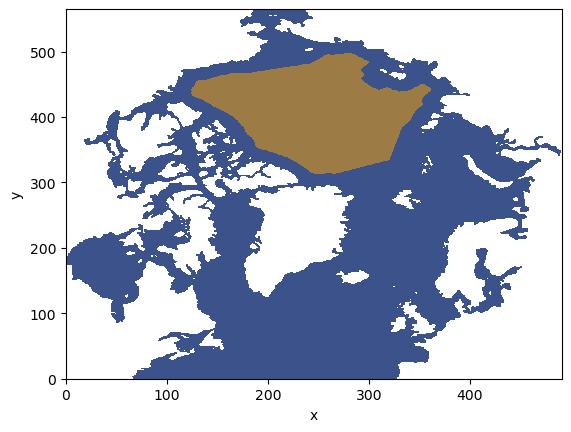

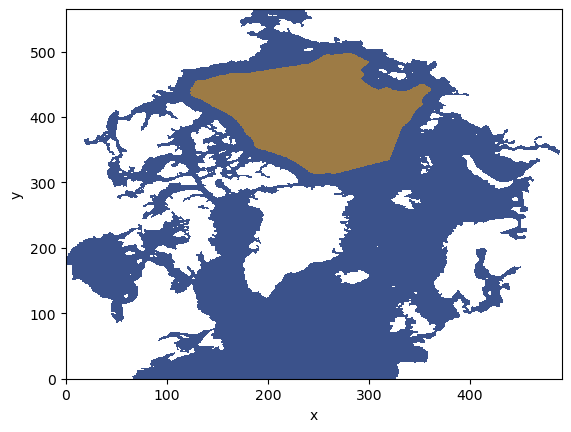

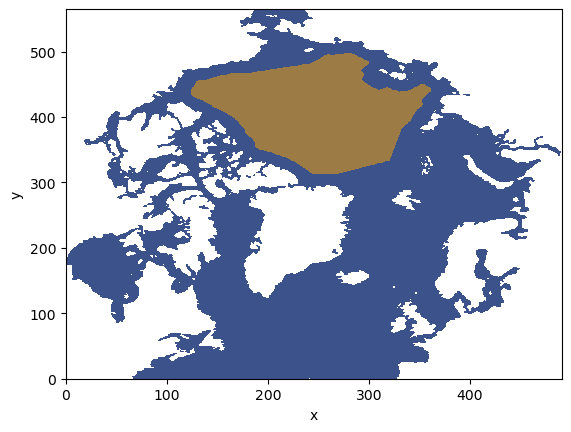

In [3]:
#Loading the mask files that interest us for graphical display

dat_masks=xr.open_dataset("/Users/fioll/Documents/IABP_buoys/masks_files/mesh_mask_NANUK4_L31_4.2_1stLev.nc")
dat_masks_domain=xr.open_dataset("/Users/fioll/Documents/IABP_buoys/masks_files/masks_domain_threshold_0.5.nc")

##Visualization of the global and domain masks

plt.contourf(dat_masks.tmask[0,0,:,:].where(dat_masks.tmask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.tmask.where(dat_masks_domain.tmask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

plt.contourf(dat_masks.umask[0,0,:,:].where(dat_masks.umask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.umask.where(dat_masks_domain.umask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

plt.contourf(dat_masks.vmask[0,0,:,:].where(dat_masks.vmask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.vmask.where(dat_masks_domain.vmask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

### Computing of the velocity

We project the position of our buoys onto a Cartesian coordinate system in order to recompute the velocity of the buoys from their positions in time. These velocities are then used to look at the trajectories. In the end, we choose not to flag the positions with very high velocities.

In [4]:
#Some useful functions

def projGeo2Cartesian(lat,lon):
    '''''
    This fonctions transforms geographic coordinate (lat,lon) in degrees into cartesian (x,y) in m with RGPS' 'NorthPolarStereo' projection.
    It is the same projection as the one used in sitrack.
    lat = latitude values
    lon = longitude values
    Warning: lat, lon should just contain values (not a DataArray or equivalent)
    '''''
    crs_src=ccrs.PlateCarree()
    crs_trg =ccrs.NorthPolarStereo(central_longitude=-45., true_scale_latitude=70.)

    zx,zy,_ = crs_trg.transform_points(crs_src, lon, lat).T
    x_pos,y_pos=zx.T,zy.T
    return (x_pos,y_pos)

def velocity(x1,x2,y1,y2,delta_t):
    '''''
    Velocity computes knowing the positions (x1,y1) and (x2,y2). These positions are those of the same buoy separated by delta_t seconds.
    For having a velocity in m/s the positions should be in meters and the time in seconds.
    '''''
    dist=np.sqrt((x2-x1)**2+(y2-y1)**2)
    return dist/delta_t

In [5]:
#Projection of the geographic coordinate of our buoys into a cartesian plan
x_pos,y_pos=projGeo2Cartesian(dat_buoys.latitude.data,dat_buoys.longitude.data)
print(np.shape(x_pos),np.shape(y_pos),np.shape(dat_buoys.latitude),np.shape(dat_buoys.longitude))

(2935, 40) (2935, 40) (2935, 40) (2935, 40)


In [6]:
#Computing of the velocities

##Definition our time interval
print((dat_buoys.time[1:].values-dat_buoys.time[:-1].values).min()) #check that it corresponds to 3 hours everywhere
print((dat_buoys.time[1:].values-dat_buoys.time[:-1].values).max()) #check that it corresponds to 3 hours everywhere
delta_t=3*3600 ; print("delta_t in seconds",delta_t)

##Computing of the velocities
velo=velocity(x_pos[:-1,:],x_pos[1:,:],y_pos[:-1,:],y_pos[1:,:],delta_t)
print(np.shape(velo))

10800000000000 nanoseconds
10800000000000 nanoseconds
delta_t in seconds 10800
(2934, 40)


### Identifying the periods of interest

The 13 periods we consider here are:

- from 1997-01-16 00:00:00 to 1997-01-26 00:00:00
- from 1997-01-26 00:00:00 to 1997-02-05 00:00:00
- from 1997-02-05 00:00:00 to 1997-02-15 00:00:00
- from 1997-02-15 00:00:00 to 1997-02-25 00:00:00
- from 1997-02-25 00:00:00 to 1997-03-07 00:00:00
- from 1997-03-07 00:00:00 to 1997-03-17 00:00:00
- from 1997-03-17 00:00:00 to 1997-03-27 00:00:00
- from 1997-03-27 00:00:00 to 1997-04-06 00:00:00
- from 1997-04-06 00:00:00 to 1997-04-16 00:00:00
- from 1997-04-16 00:00:00 to 1997-04-26 00:00:00
- from 1997-04-26 00:00:00 to 1997-05-06 00:00:00
- from 1997-05-06 00:00:00 to 1997-05-16 00:00:00
- from 1997-05-16 00:00:00 to 1997-05-26 00:00:00

In [7]:
#Defining the periods of interest

start_seed_date=["1997-01-16 00:00:00","1997-01-26 00:00:00","1997-02-05 00:00:00","1997-02-15 00:00:00","1997-02-25 00:00:00",\
                "1997-03-07 00:00:00","1997-03-17 00:00:00","1997-03-27 00:00:00","1997-04-06 00:00:00","1997-04-16 00:00:00",\
                "1997-04-26 00:00:00","1997-05-06 00:00:00","1997-05-16 00:00:00"]

str_time_buoy=dat_buoys.time.dt.strftime("%Y-%m-%d %H:%M:%S") #convert time of dat_buoys into a string of characters
#print(dat_buoys.time[120:133].values,str_time_buoy[120:133].values)

##Saving the position in dat_buoys of the time of the seeding
pos_start_seed_date=[] #list that will contain the positions
for date_seed in start_seed_date:
    pos_start_seed_date.append(np.where(str_time_buoy==date_seed)[0][0])
print(pos_start_seed_date)

posdiff_end_seed_date=10*8 #what needs to be added to be at the end of the period of interest

##Checking everything okay
for posdate in pos_start_seed_date:
    print(dat_buoys.time[posdate].values,dat_buoys.time[posdate+posdiff_end_seed_date].values)

[129, 209, 289, 369, 449, 529, 609, 689, 769, 849, 929, 1009, 1089]
1997-01-16T00:00:00.000000000 1997-01-26T00:00:00.000000000
1997-01-26T00:00:00.000000000 1997-02-05T00:00:00.000000000
1997-02-05T00:00:00.000000000 1997-02-15T00:00:00.000000000
1997-02-15T00:00:00.000000000 1997-02-25T00:00:00.000000000
1997-02-25T00:00:00.000000000 1997-03-07T00:00:00.000000000
1997-03-07T00:00:00.000000000 1997-03-17T00:00:00.000000000
1997-03-17T00:00:00.000000000 1997-03-27T00:00:00.000000000
1997-03-27T00:00:00.000000000 1997-04-06T00:00:00.000000000
1997-04-06T00:00:00.000000000 1997-04-16T00:00:00.000000000
1997-04-16T00:00:00.000000000 1997-04-26T00:00:00.000000000
1997-04-26T00:00:00.000000000 1997-05-06T00:00:00.000000000
1997-05-06T00:00:00.000000000 1997-05-16T00:00:00.000000000
1997-05-16T00:00:00.000000000 1997-05-26T00:00:00.000000000


### Identifying the buoys of interest for each period

In [8]:
#First, we look only at the buoys with data over the whole period

pos_buoys_period=[] #list that will contain the position of the buoys that will interest us for the following

print("maximum number of values possible over one period",posdiff_end_seed_date+1)
for posdate in pos_start_seed_date: #iteration over the periods of interest
    print("//")
    print(dat_buoys.time[posdate:posdate+posdiff_end_seed_date+1][0].values,dat_buoys.time[posdate:posdate+posdiff_end_seed_date+1][-1].values)
    print(dat_buoys.mask[posdate:posdate+posdiff_end_seed_date+1,:].sum("time").values)
    pos_buoys_period.append(np.where((dat_buoys.mask[posdate:posdate+posdiff_end_seed_date+1,:].sum("time"))==(posdiff_end_seed_date+1))[0])
    print(len(pos_buoys_period[-1]),pos_buoys_period[-1])
    print(dat_buoys.id_buoy[pos_buoys_period[-1]].values)

maximum number of values possible over one period 81
//
1997-01-16T00:00:00.000000000 1997-01-26T00:00:00.000000000
[81 81  0  0  0  0  0  0 71  0  0 80 80 81 81 81 81 17 81 81  0  0  0 81
 81 81  0  0  0  0  0 62 81  0 81  0 81 81  0 74]
15 [ 0  1 13 14 15 16 18 19 23 24 25 32 34 36 37]
[ 1101  1103  9353  9354  9357  9358  9361  9365 19577 19578 19579 26693
 26695 26698 26699]
//
1997-01-26T00:00:00.000000000 1997-02-05T00:00:00.000000000
[81 52  0  0  0  0  0  0 81  0  0 81 81 80 81 81 81 72 81 81  0  0  0 81
 81 81  0  0  0  0  0 24 81  0 81  0 81 81  0 70]
16 [ 0  8 11 12 14 15 16 18 19 23 24 25 32 34 36 37]
[ 1101  5317  8057  8058  9354  9357  9358  9361  9365 19577 19578 19579
 26693 26695 26698 26699]
//
1997-02-05T00:00:00.000000000 1997-02-15T00:00:00.000000000
[80  5  0  0  0  0  0  0 81  0  0 81 81 81 81 81 81  0 81 81  0  0  0 81
 81 81  0  0  0  0  0 29 81  0 81  0 81 81  0 66]
16 [ 8 11 12 13 14 15 16 18 19 23 24 25 32 34 36 37]
[ 5317  8057  8058  9353  9354  9357  935

['1997-02-05T00:00:00.000000000' '1997-02-07T00:00:00.000000000'
 '1997-02-09T00:00:00.000000000' '1997-02-11T00:00:00.000000000'
 '1997-02-13T00:00:00.000000000' '1997-02-15T00:00:00.000000000']
81 81 81


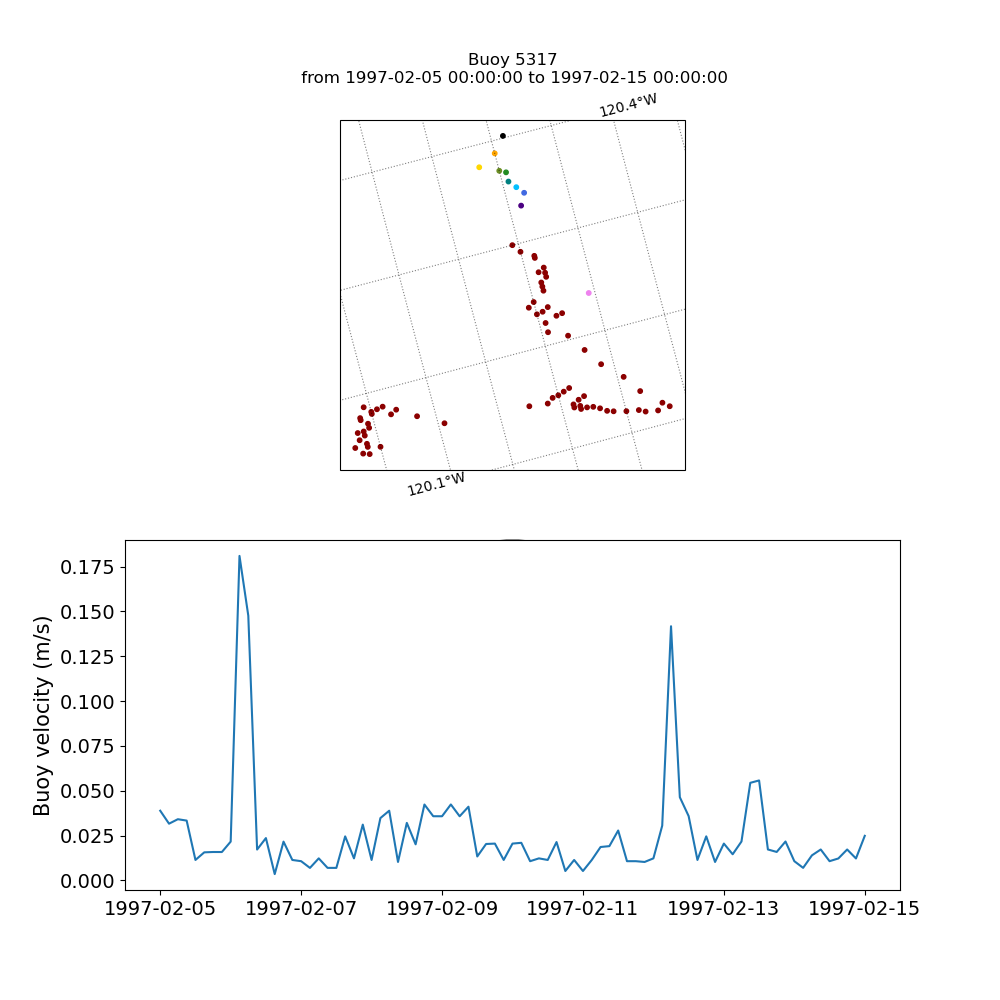

81 81 81


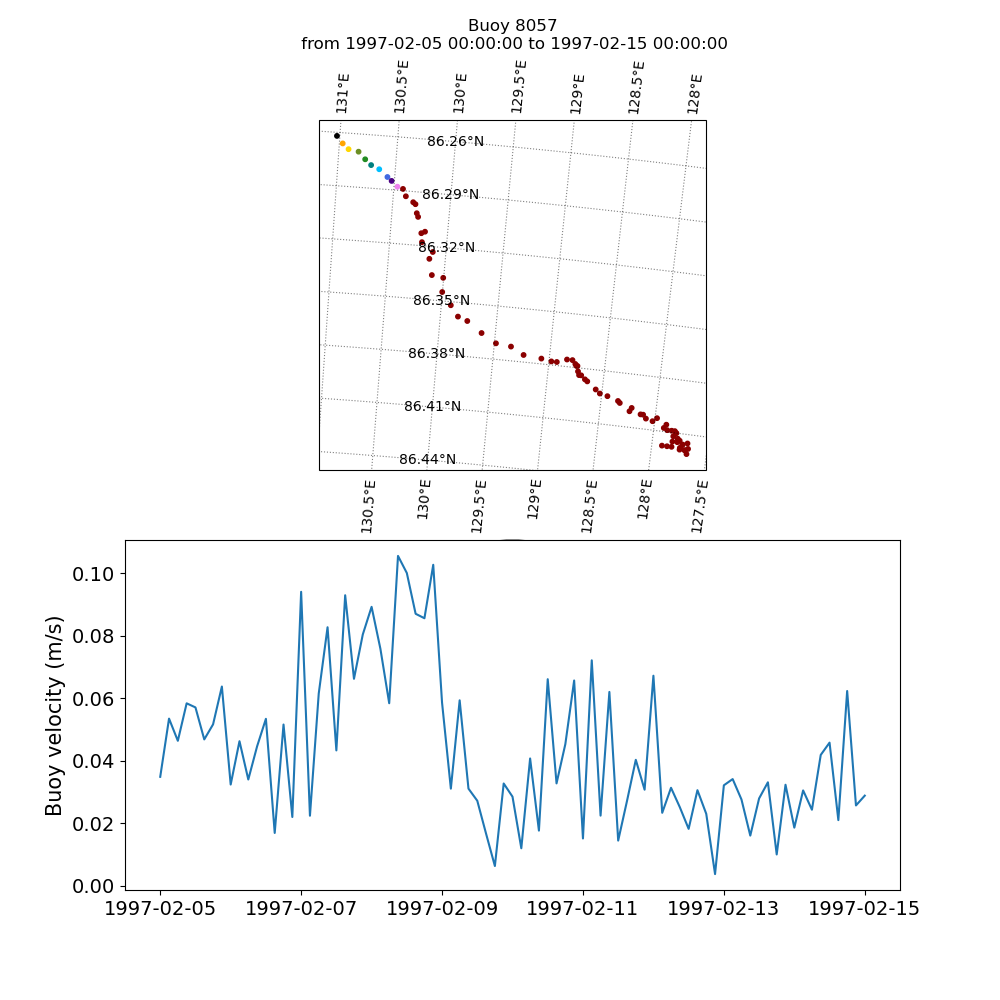

81 81 81


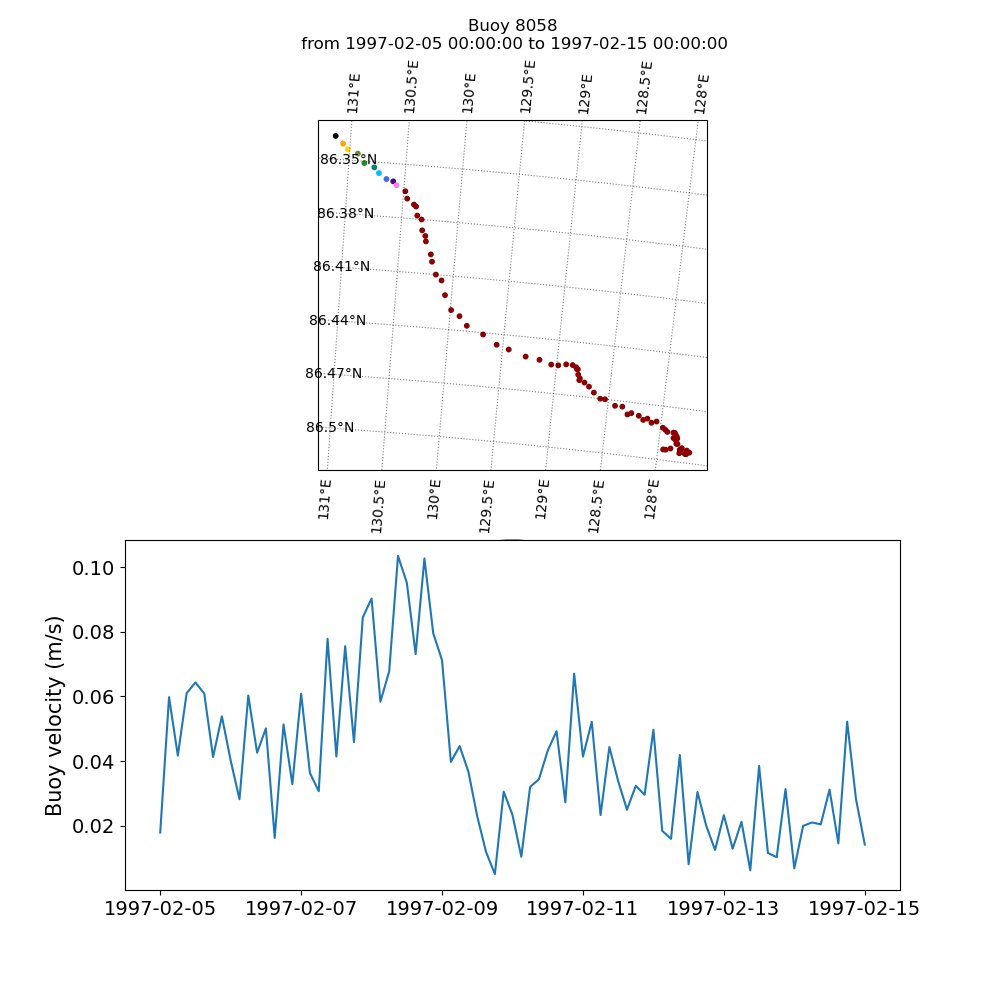

81 81 81


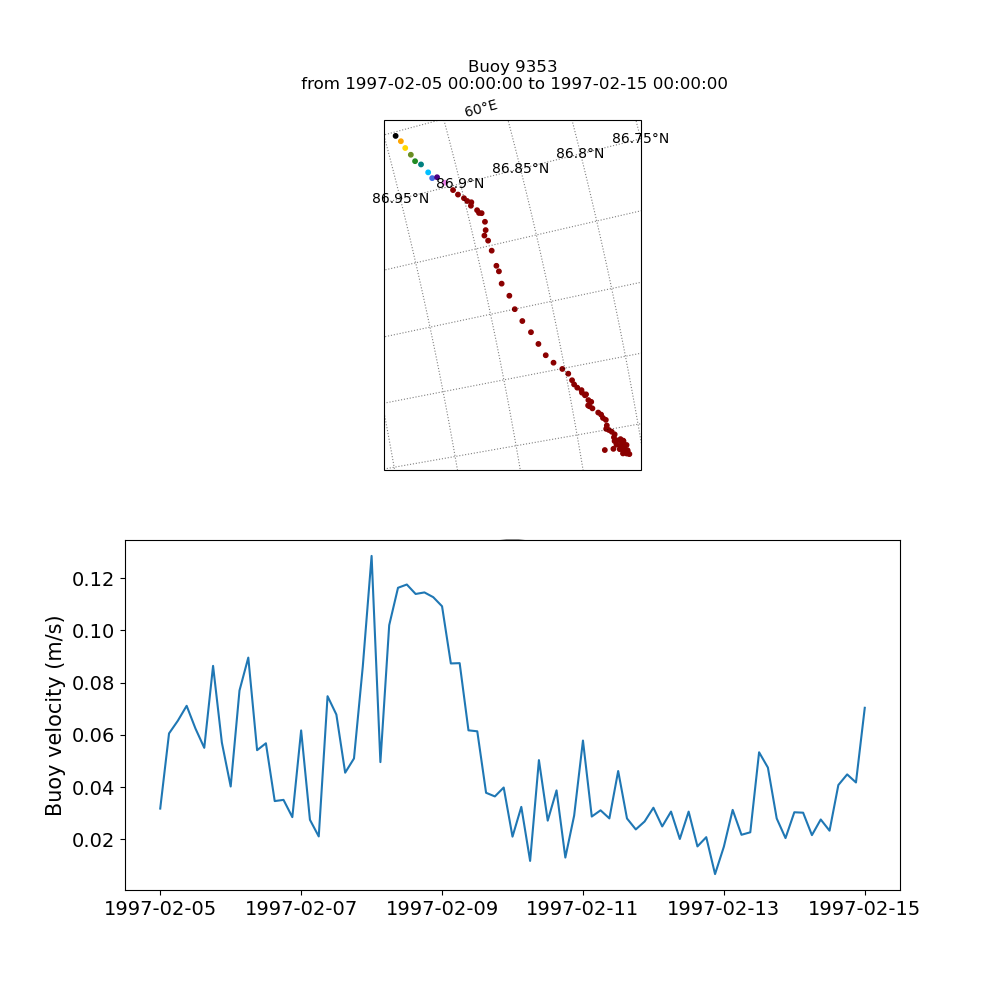

81 81 81


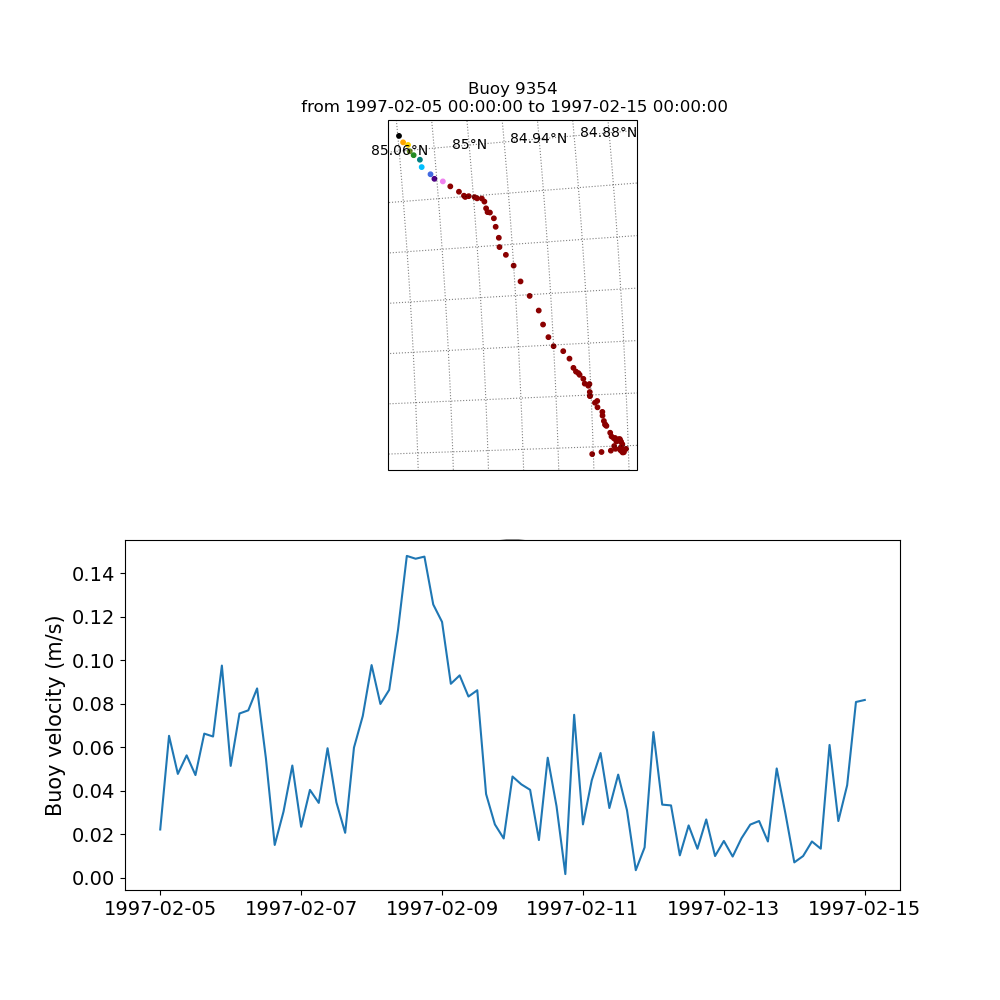

81 81 81


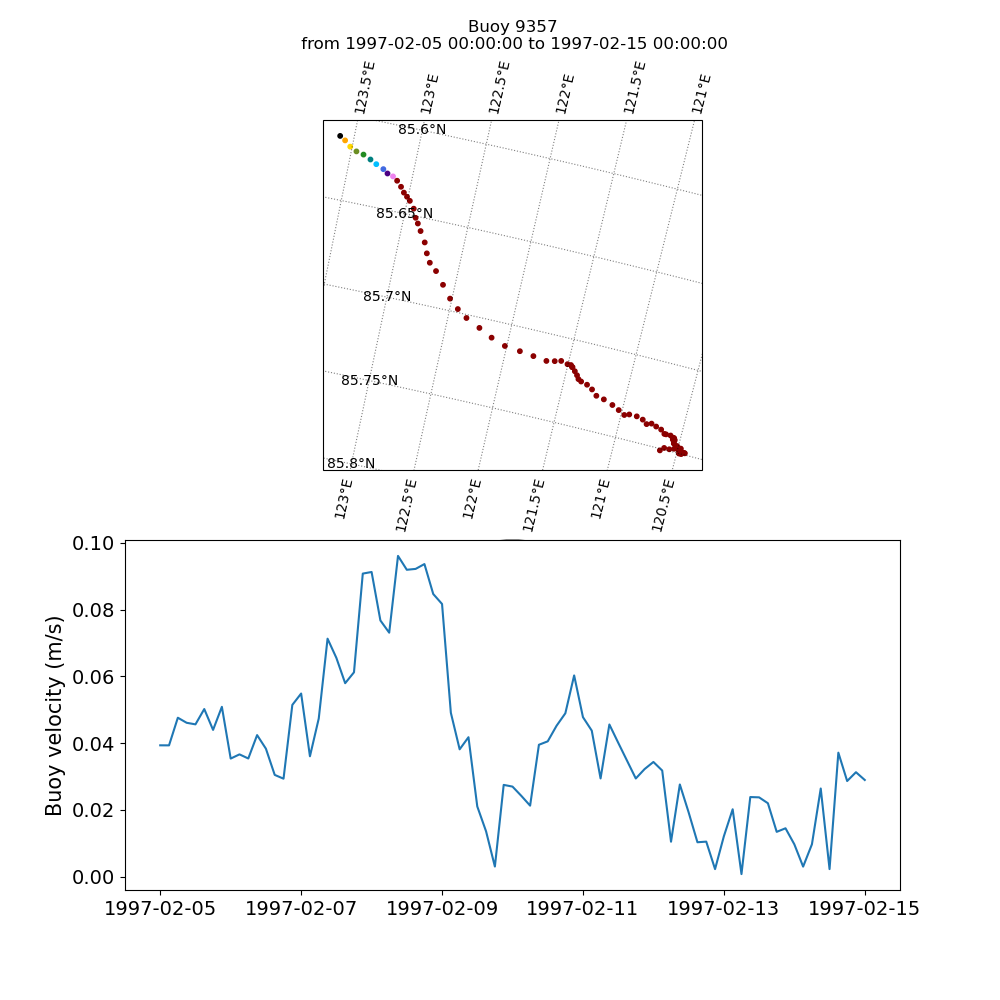

81 81 81


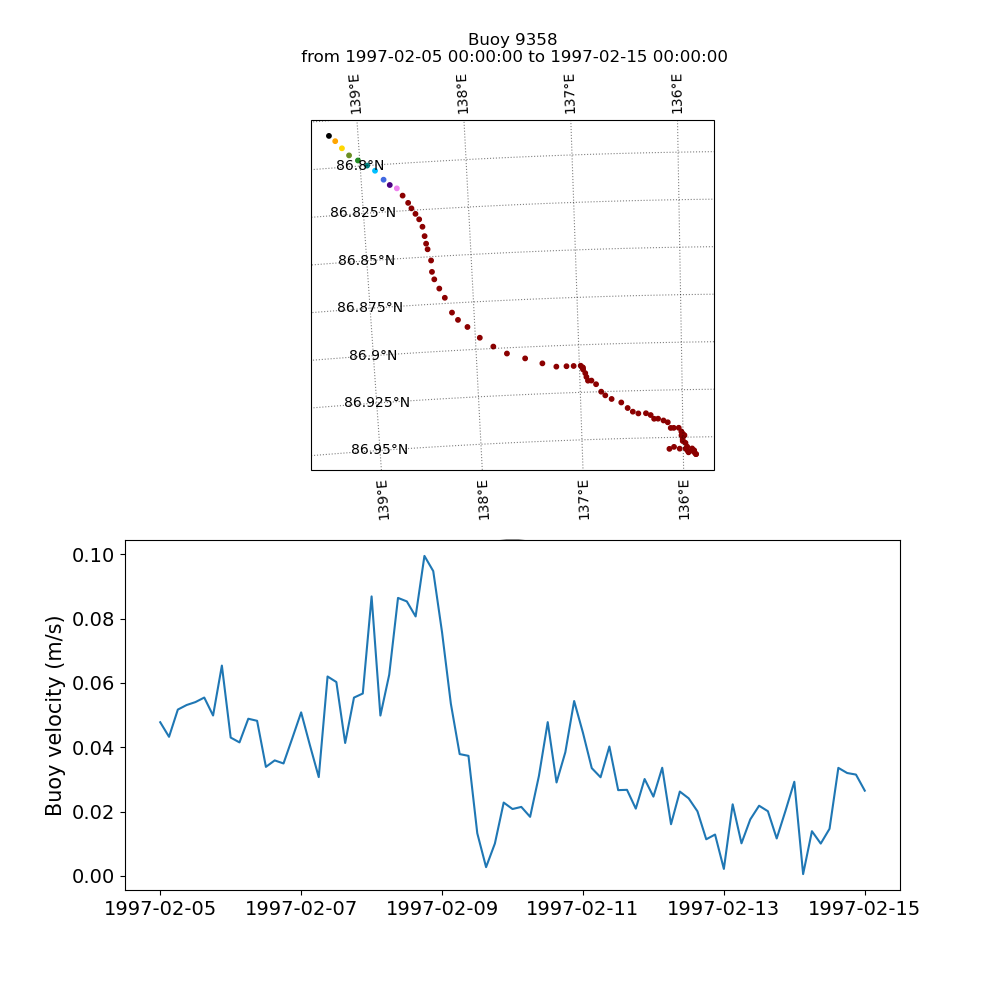

81 81 81


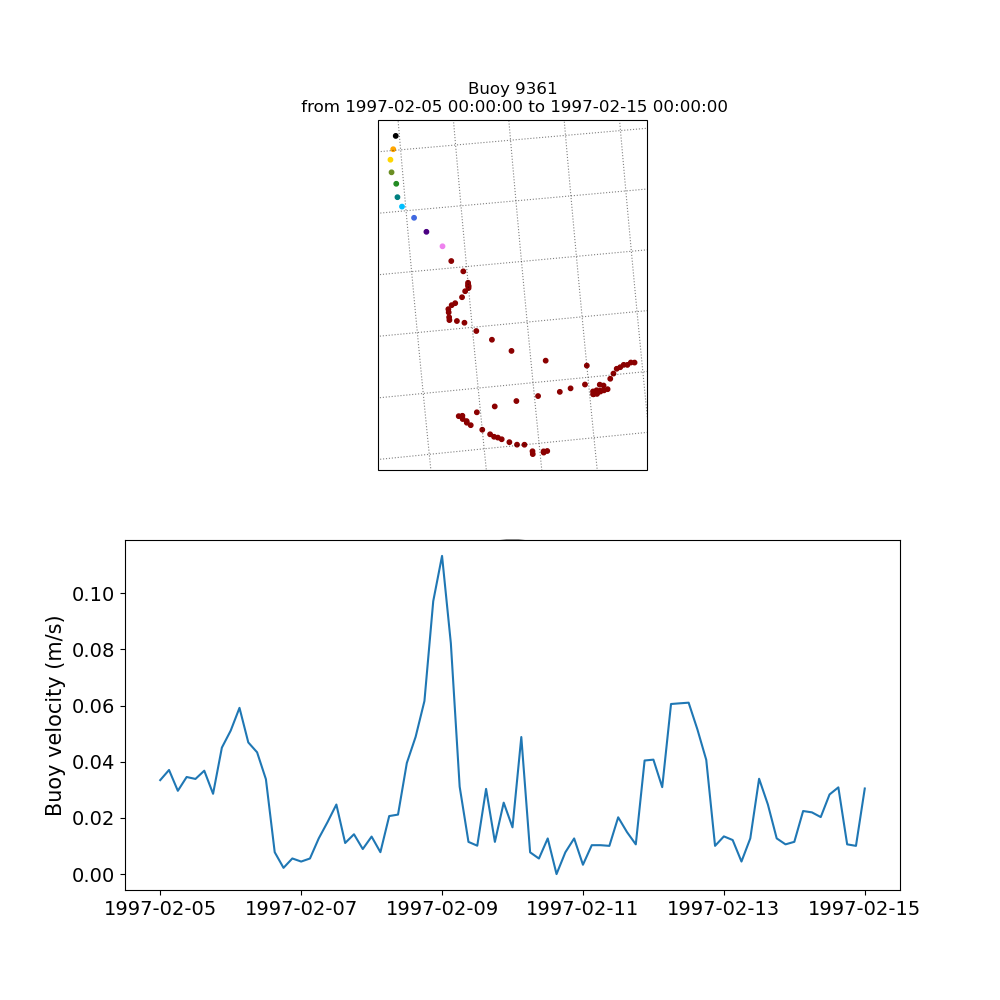

81 81 81


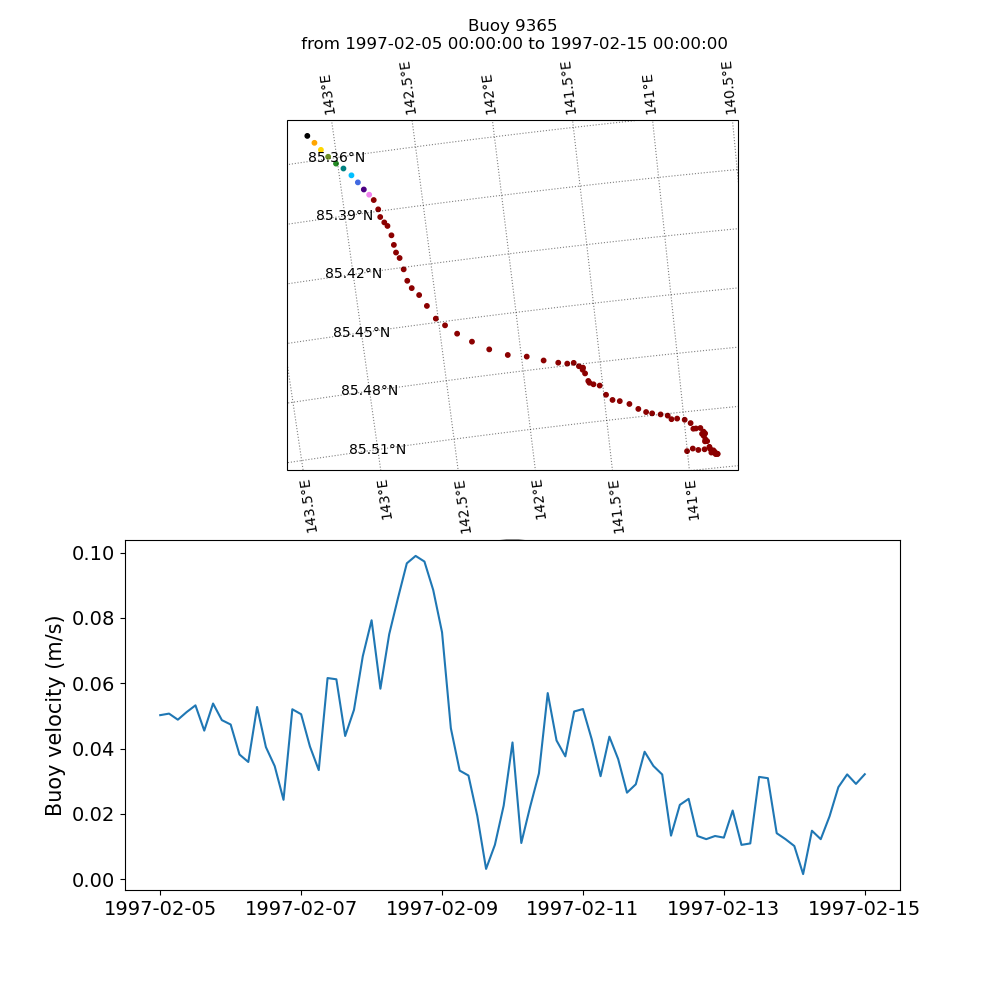

81 81 81


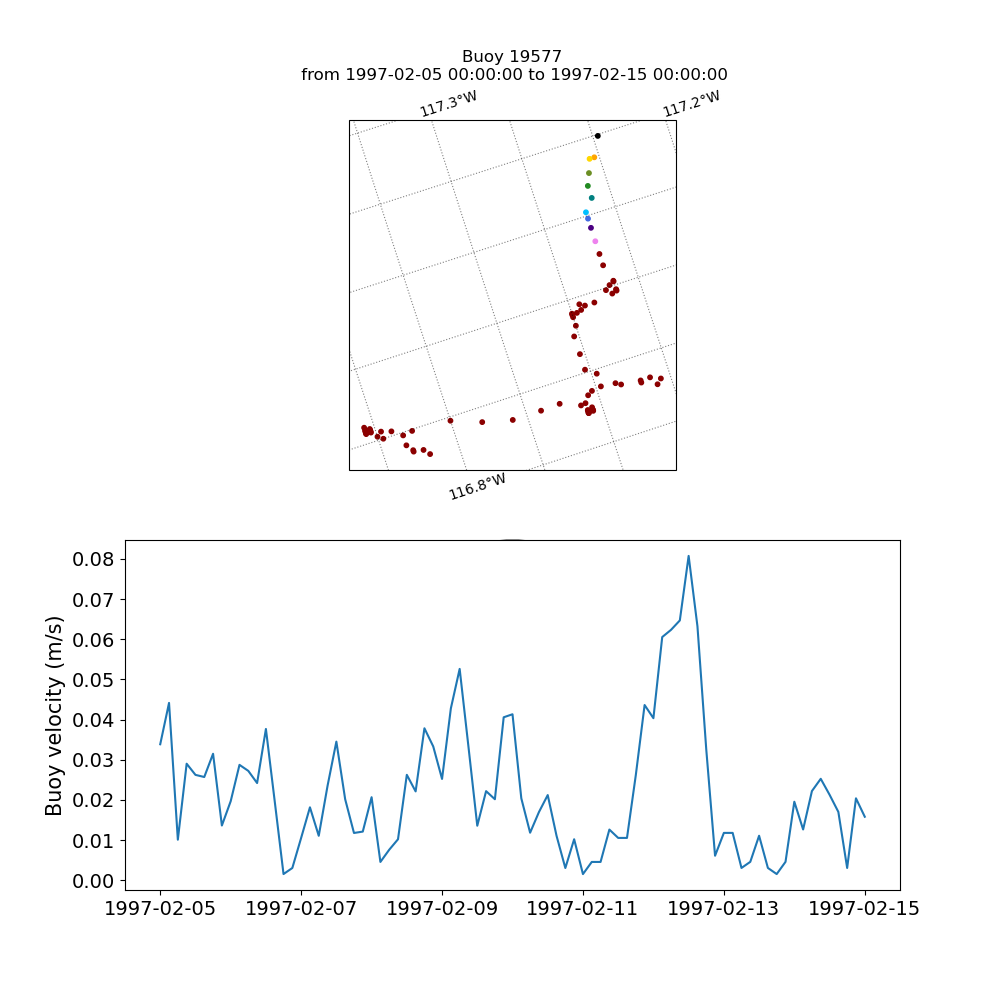

81 81 81


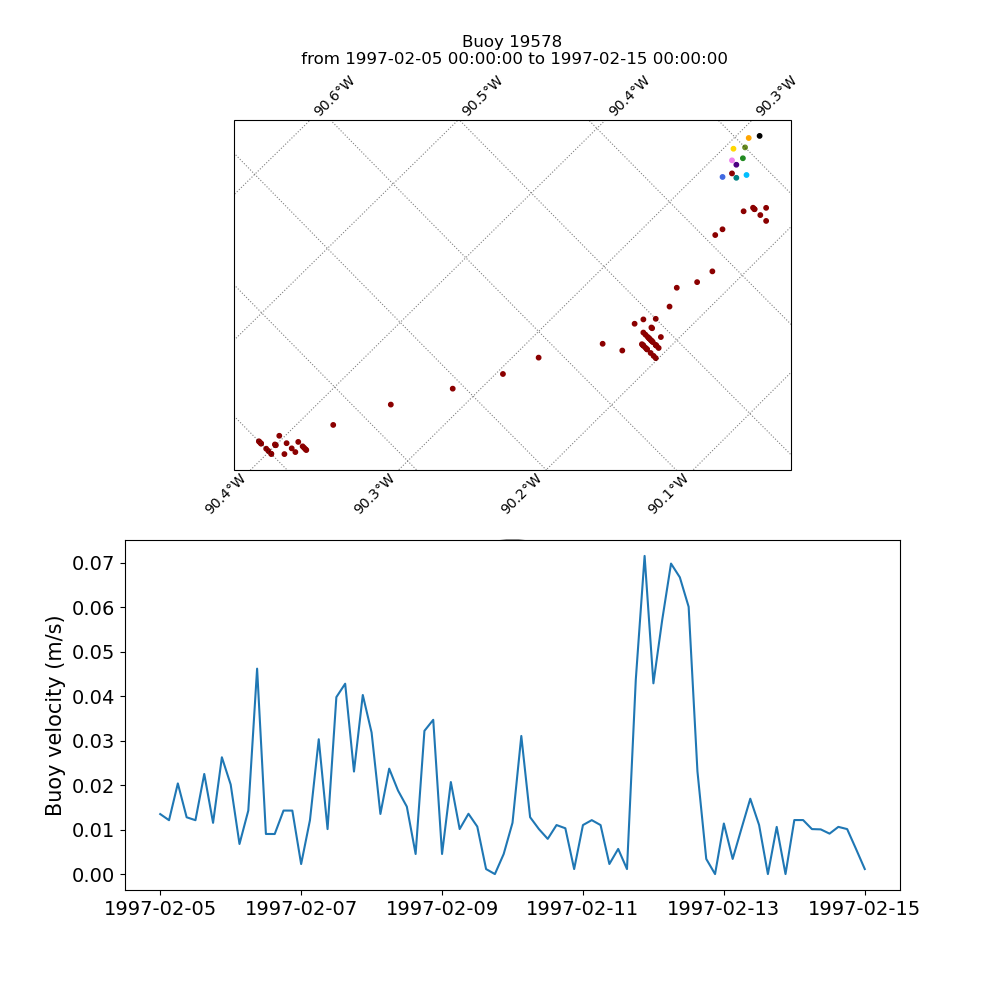

81 81 81


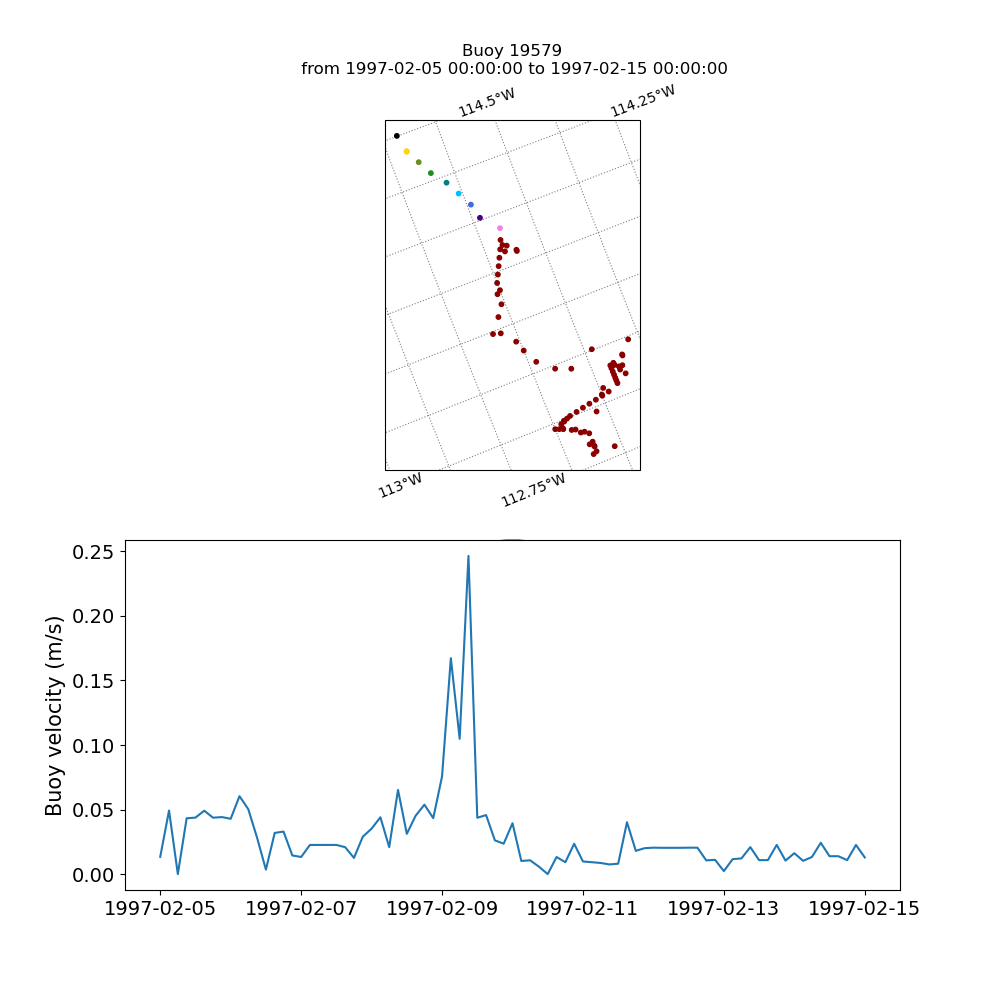

81 81 81


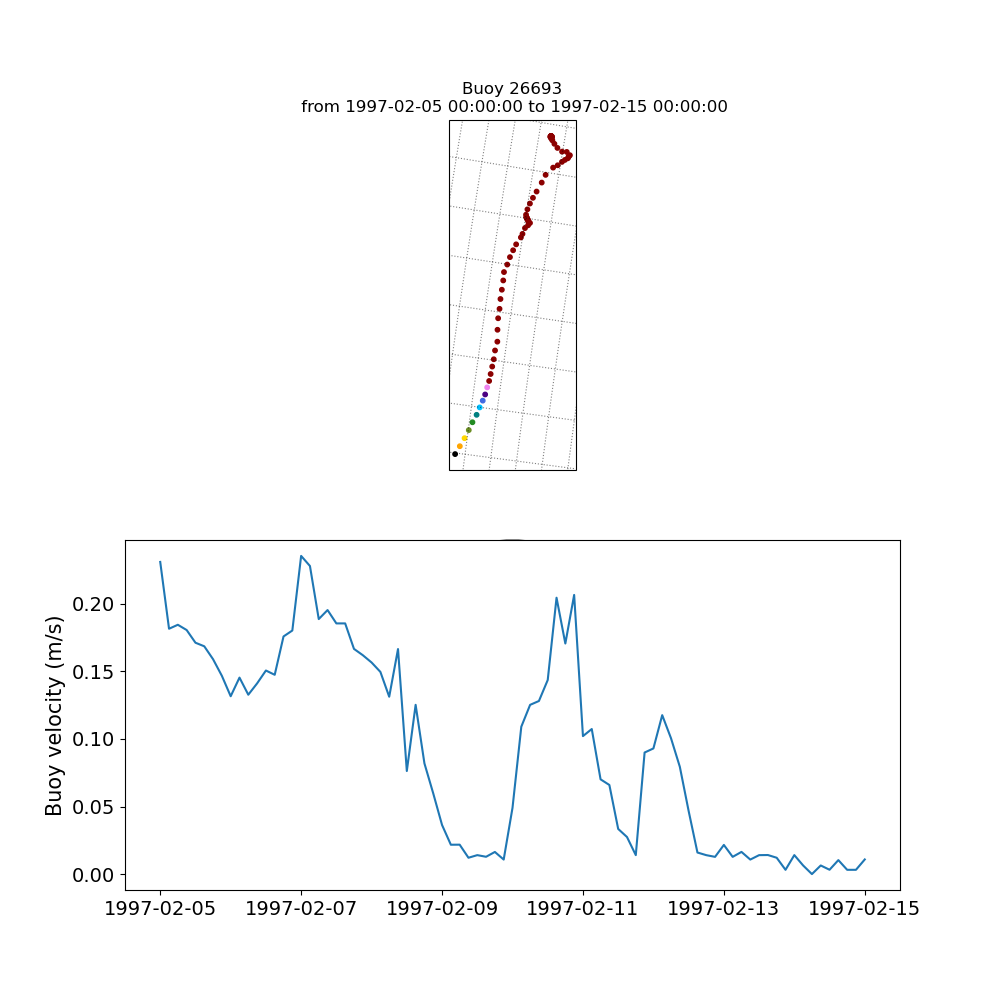

81 81 81


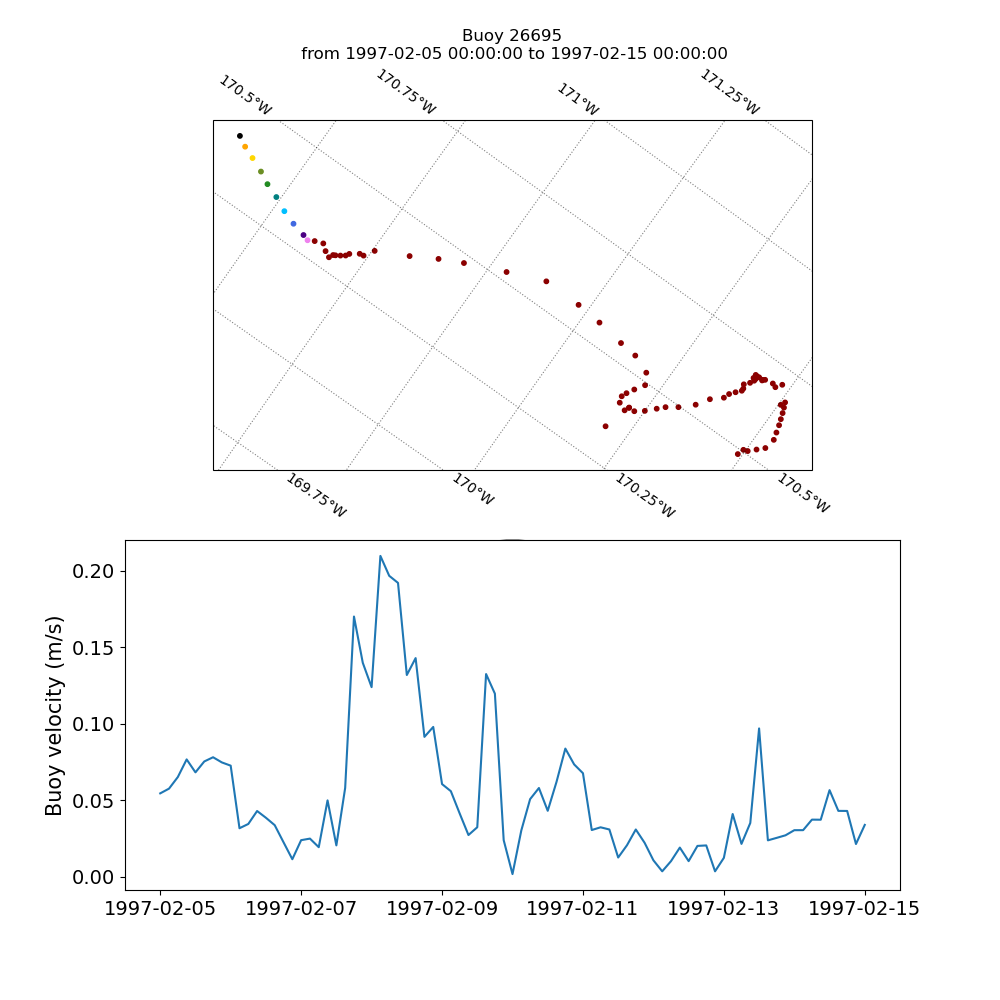

81 81 81


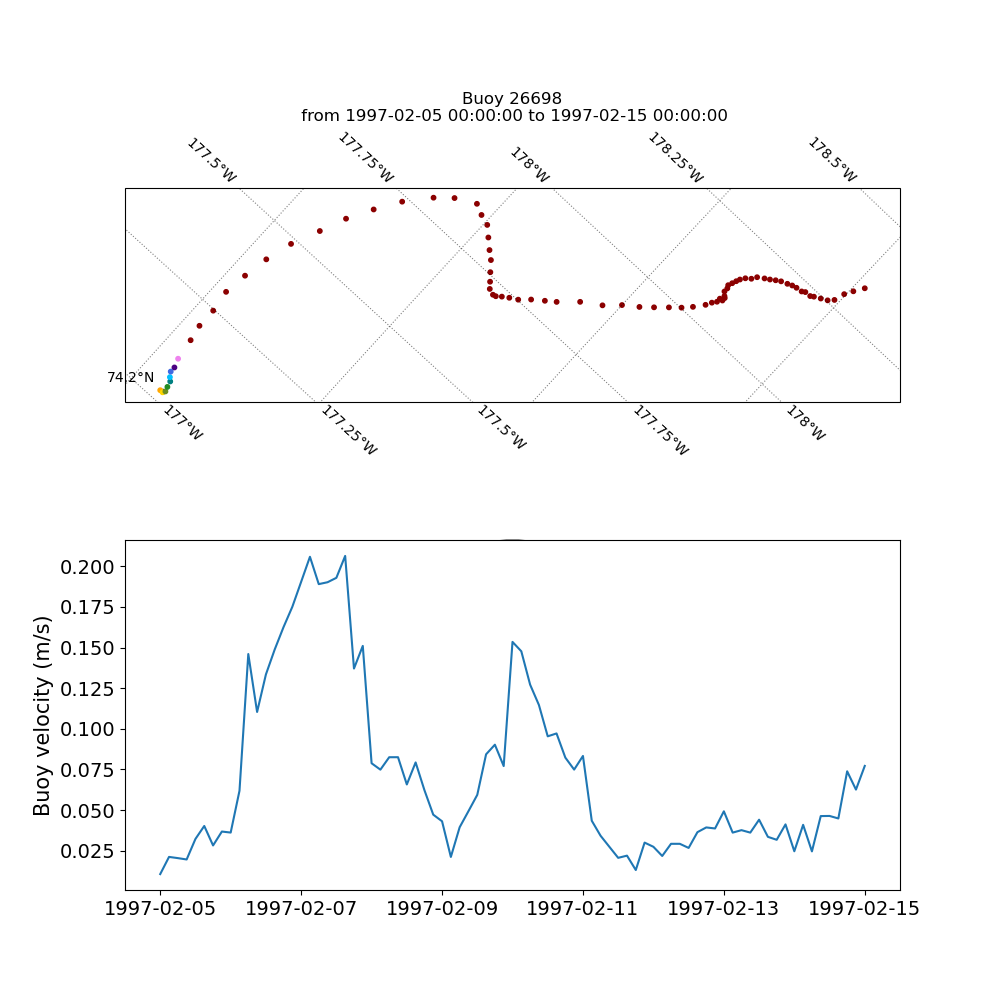

81 81 81


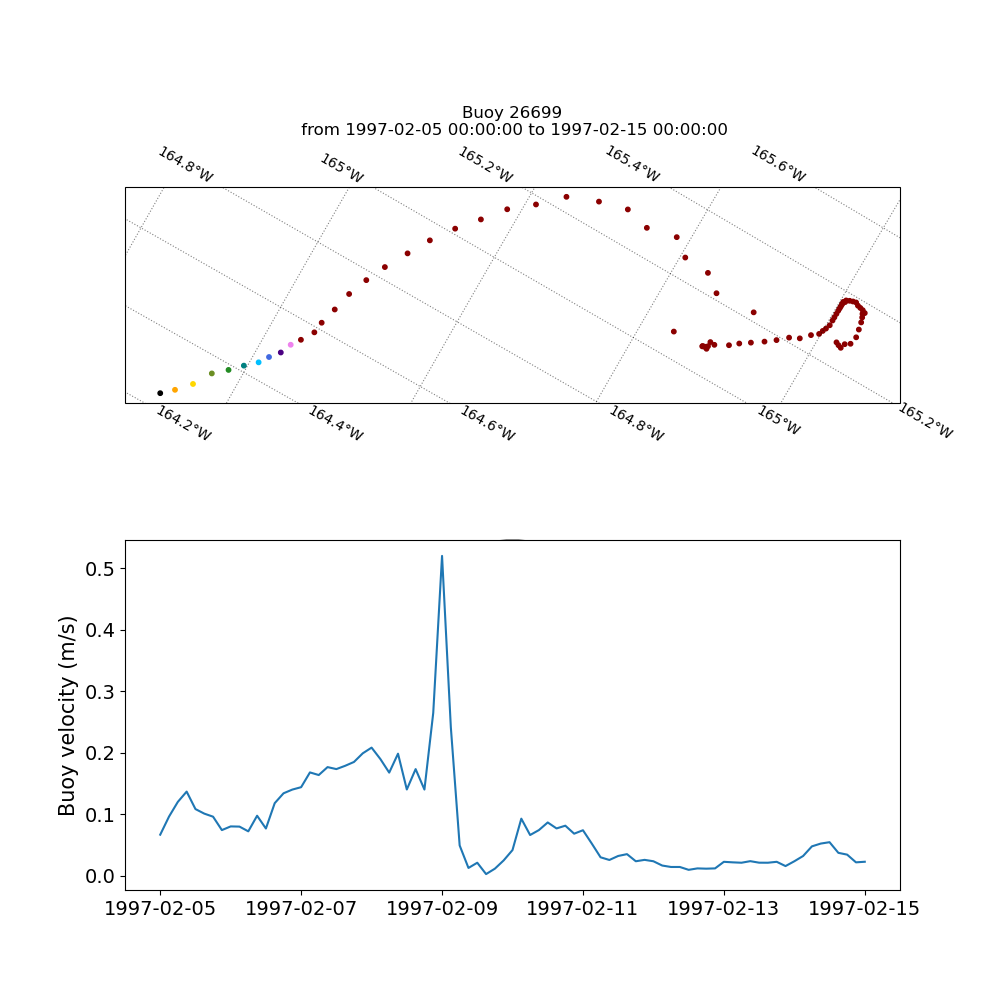

In [9]:
#Visualisation of the trajectories of the buoys selected above

##to have an interactive interface
%matplotlib widget 

##Choose the kind of figure we want
#extent="full" #positions on the Arctic map
extent="local" #closer look on the trajectories

##Iteration over the periods of interest
#for period_interest in range(len(pos_start_seed_date)):
for period_interest in [2]: #for some selected periods

    start=pos_start_seed_date[period_interest] ; end=start+posdiff_end_seed_date #begin and end of our time interval
    xticks_val=dat_buoys.time[start:end+1:16]
    print(xticks_val.values)
    
    for ib in pos_buoys_period[period_interest]: #iteration over the buoys of interest

        ##Creation of the figure and chose of the projection of interest
        #fig,(ax1,ax2)= plt.subplots(2,1,figsize=(10,10),facecolor="white",subplot_kw={ 'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0) })
        fig,(ax1,ax2)= plt.subplots(2,1,figsize=(10,10),facecolor="white",subplot_kw={ 'projection': ccrs.NorthPolarStereo(central_longitude=-45., true_scale_latitude=70.) })
        trdata=ccrs.PlateCarree()

        ##Plot over a map of the positions (lat, lon) of the buoy over time
            ##different colors for the first 10 points
        colors=["black","orange","gold","olivedrab","forestgreen","teal","deepskyblue","royalblue","indigo","violet"]+["darkred" for _ in range(posdiff_end_seed_date+1-10)]
        print(len(colors),len(dat_buoys.longitude[start:end+1,ib]),len(dat_buoys.latitude[start:end+1,ib]))
        ax1.scatter(dat_buoys.longitude[start:end+1,ib],dat_buoys.latitude[start:end+1,ib],s=10,transform=trdata,c=colors,zorder=1)
        ax1.set_title("Buoy "+str(dat_buoys.id_buoy[ib].values)+"\n from "+str(dat_buoys.time.to_index()[start])+" to "+str(dat_buoys.time.to_index()[end]))

        ##Set up the background and of the axes
        land = cfeature.GSHHSFeature(scale="intermediate",levels=[1],facecolor="#727171")
        ax1.add_feature(land,zorder=-1)
        
        gl = ax1.gridlines(draw_labels=True, linestyle=':', color='black',
                          alpha=0.5)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax1.tick_params('both',labelsize=22)

        ##Set up some features in the case we don't want a zoomed figure
        if extent=="full":
            ax1.set_extent([-180, 180, 60, 90],trdata)
            ax1.pcolormesh(dat_masks.nav_lon,dat_masks.nav_lat,dat_masks_domain.tmask.where(dat_masks_domain.tmask>0),transform=trdata,shading="gouraud",cmap="twilight",zorder=-1)

        ##Plot the velocity time series
        ax2 = fig.add_subplot(2, 1, 2)  # standard matplotlib Axes
        ax2.plot(dat_buoys.time[start:end+1],velo[start-1:end,ib])
        ax2.set_ylabel("Buoy velocity (m/s)",fontsize=15)
        ax2.tick_params('both',labelsize=14)
        ax2.set_xticks(xticks_val)

        plt.show()
        ##Saving the figure
        #fig.savefig("/Users/fioll/Documents/IABP_buoys/Figures/period"+str(period_interest+1)+"/IABP_buoy"+str(dat_buoys.id_buoy[ib].values)+"_"+extent+"_from_t"+str(start)+".png",\
        #    facecolor="white",edgecolor="none",bbox_inches="tight")
        #plt.close(fig)

In [10]:
#Identifying potential additionnal buoys we could also consider
#2 criteria: at least 73 values (about 90%) over the period and the first value of the period exist

add_pos_buoys_period=[] #list that will contain the position of potential additionnal buoys

for posdate in pos_start_seed_date:
    print("//")
    print(dat_buoys.time[posdate:posdate+posdiff_end_seed_date+1][0].values,\
          dat_buoys.time[posdate:posdate+posdiff_end_seed_date+1][-1].values)
    sum_period=(dat_buoys.mask[posdate:posdate+posdiff_end_seed_date+1,:].sum("time")) #number of values over the period per buoy
    print(sum_period.values)
    print(dat_buoys.mask[posdate,:].values)

    add_pos_buoys_period.append(np.where((sum_period*dat_buoys.mask[posdate,:]*(sum_period!=81))>=73)[0]) #saving of buoys meeting both criteria
    print(len(add_pos_buoys_period[-1]),add_pos_buoys_period[-1])
    print(dat_buoys.id_buoy[add_pos_buoys_period[-1]].values)

//
1997-01-16T00:00:00.000000000 1997-01-26T00:00:00.000000000
[81 81  0  0  0  0  0  0 71  0  0 80 80 81 81 81 81 17 81 81  0  0  0 81
 81 81  0  0  0  0  0 62 81  0 81  0 81 81  0 74]
[1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1
 1 0 1]
3 [11 12 39]
[      8057       8058 1066717987]
//
1997-01-26T00:00:00.000000000 1997-02-05T00:00:00.000000000
[81 52  0  0  0  0  0  0 81  0  0 81 81 80 81 81 81 72 81 81  0  0  0 81
 81 81  0  0  0  0  0 24 81  0 81  0 81 81  0 70]
[1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1
 1 0 1]
1 [13]
[9353]
//
1997-02-05T00:00:00.000000000 1997-02-15T00:00:00.000000000
[80  5  0  0  0  0  0  0 81  0  0 81 81 81 81 81 81  0 81 81  0  0  0 81
 81 81  0  0  0  0  0 29 81  0 81  0 81 81  0 66]
[1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1
 1 0 1]
1 [0]
[1101]
//
1997-02-15T00:00:00.000000000 1997-02-25T00:00:00.000000000
[81  5  0  0  0  0  0  0 81  0  0 81 81 81 81 81 81 36 

['1997-05-16T00:00:00.000000000' '1997-05-18T00:00:00.000000000'
 '1997-05-20T00:00:00.000000000' '1997-05-22T00:00:00.000000000'
 '1997-05-24T00:00:00.000000000' '1997-05-26T00:00:00.000000000']
81 81 81


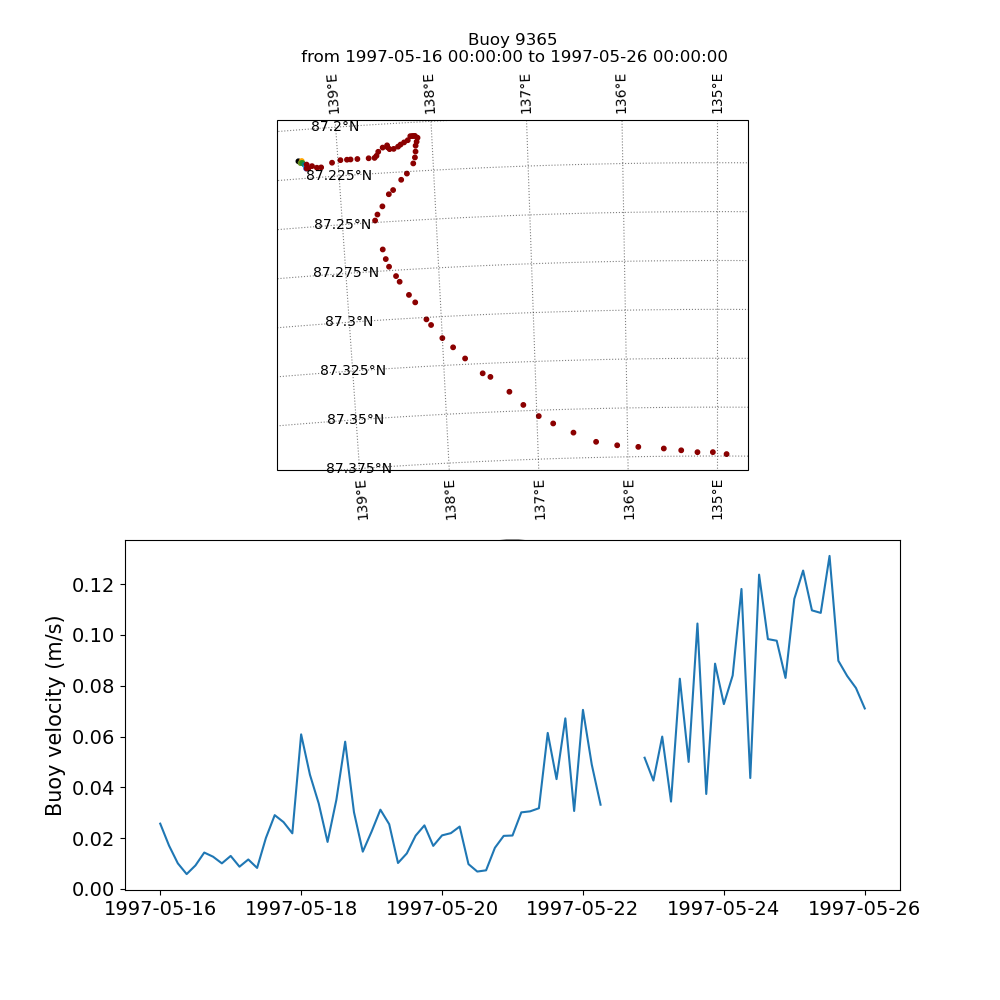

81 81 81


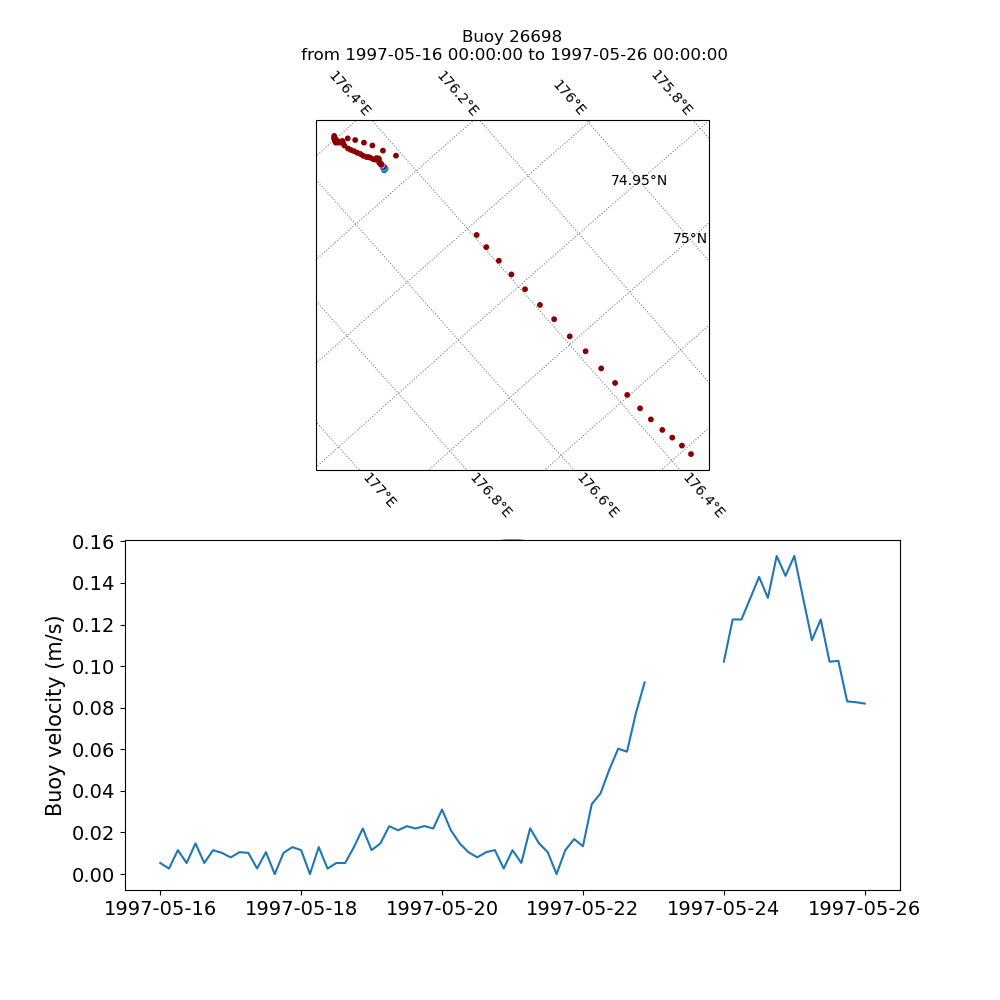

81 81 81


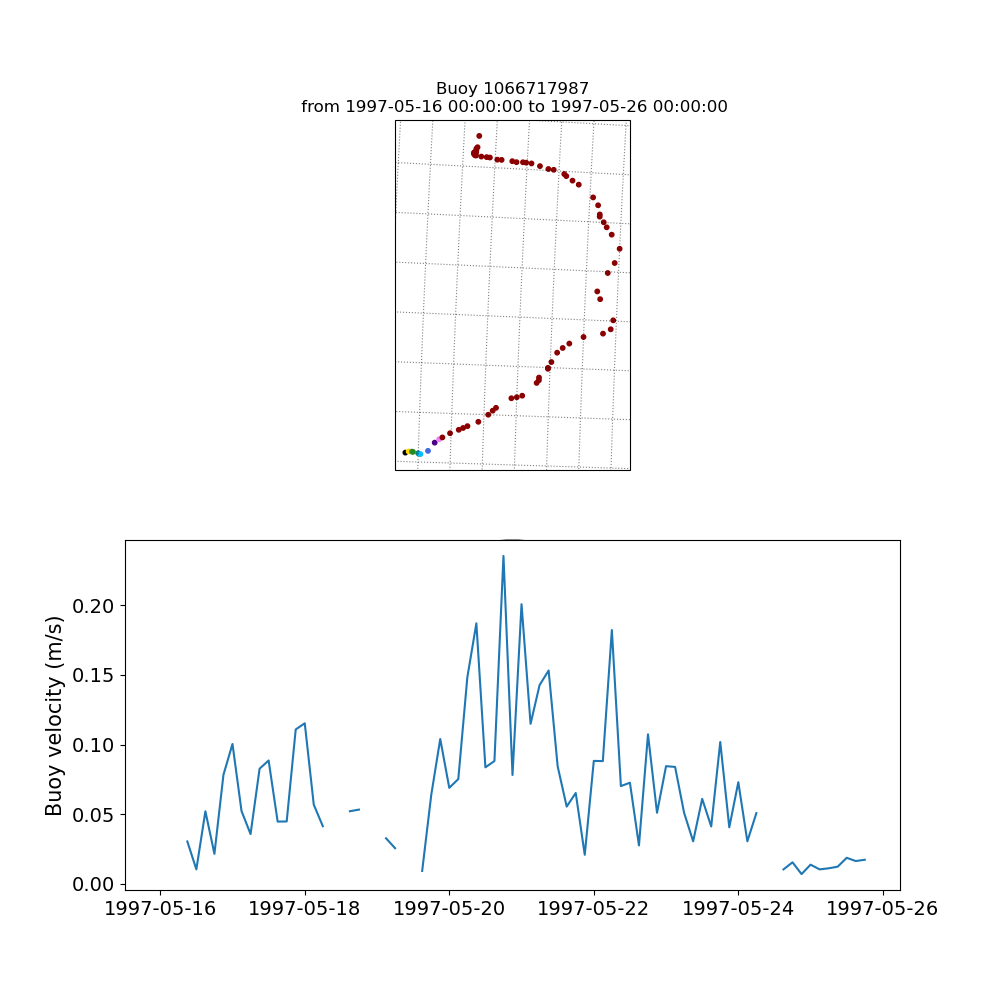

In [11]:
#Visualisation of the trajectories of the buoys selected above

##to have an interactive interface
%matplotlib widget

##Choose the kind of figure we want
#extent="full" #positions on the Arctic map
extent="local" #closer look on the trajectories

##Iteration over the periods of interest
#for period_interest in range(len(pos_start_seed_date)):
for period_interest in [12]: #for some selected periods

    start=pos_start_seed_date[period_interest] ; end=start+posdiff_end_seed_date #begin and end of our time interval
    xticks_val=dat_buoys.time[start:end+1:16]
    print(xticks_val.values)
    
    for ib in add_pos_buoys_period[period_interest]: #iteration over the buoys of interest

        ##Creation of the figure and chose of the projection of interest
        #fig,(ax1,ax2)= plt.subplots(2,1,figsize=(10,10),facecolor="white",subplot_kw={ 'projection': ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0) })
        fig,(ax1,ax2)= plt.subplots(2,1,figsize=(10,10),facecolor="white",subplot_kw={ 'projection': ccrs.NorthPolarStereo(central_longitude=-45., true_scale_latitude=70.) })
        trdata=ccrs.PlateCarree()

        ##Plot over a map of the positions (lat, lon) of the buoy over time
            ##different colors for the first 10 points
        colors=["black","orange","gold","olivedrab","forestgreen","teal","deepskyblue","royalblue","indigo","violet"]+["darkred" for _ in range(posdiff_end_seed_date+1-10)]
        print(len(colors),len(dat_buoys.longitude[start:end+1,ib]),len(dat_buoys.latitude[start:end+1,ib]))
        ax1.scatter(dat_buoys.longitude[start:end+1,ib],dat_buoys.latitude[start:end+1,ib],s=10,transform=trdata,c=colors,zorder=1)
        ax1.set_title("Buoy "+str(dat_buoys.id_buoy[ib].values)+"\n from "+str(dat_buoys.time.to_index()[start])+" to "+str(dat_buoys.time.to_index()[end]))

        ##Set up the background and of the axes
        land = cfeature.GSHHSFeature(scale="intermediate",levels=[1],facecolor="#727171")
        ax1.add_feature(land,zorder=-1)
        
        gl = ax1.gridlines(draw_labels=True, linestyle=':', color='black',
                          alpha=0.5)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax1.tick_params('both',labelsize=22)

        ##Set up some features in the case we don't want a zoomed figure
        if extent=="full":
            ax1.set_extent([-180, 180, 60, 90],trdata)
            ax1.pcolormesh(dat_masks.nav_lon,dat_masks.nav_lat,dat_masks_domain.tmask.where(dat_masks_domain.tmask>0),transform=trdata,shading="gouraud",cmap="twilight",zorder=-1)

        ##Plot the velocity time series
        ax2 = fig.add_subplot(2, 1, 2)  # standard matplotlib Axes
        ax2.plot(dat_buoys.time[start:end+1],velo[start-1:end,ib])
        ax2.set_ylabel("Buoy velocity (m/s)",fontsize=15)
        ax2.tick_params('both',labelsize=14)
        ax2.set_xticks(xticks_val)

        plt.show()
        ##Saving of the figure
        #fig.savefig("/Users/fioll/Documents/IABP_buoys/Figures/period"+str(period_interest+1)+"/IABP_addbuoy"+str(dat_buoys.id_buoy[ib].values)+"_"+extent+"_from_t"+str(start)+".png",\
        #    facecolor="white",edgecolor="none",bbox_inches="tight")
        #plt.close(fig)

### Final selection of the buoys

After looking at each selected trajectories individually, we select those without obvious non-physical behaviour. These selected buoys are listed below.

In [12]:
##Choose the buoys for the seeding

selected_buoys_periods=[\
["period 1",1066717987,1101,19577,19579,26693,26695,26698,26699,8057,8058,9353,9354,9357,9358,9361,9365],\
["period 2",1101,19577,19579,26693,26695,26698,26699,8057,8058,9353,9354,9357,9358,9361,9365],\
["period 3",1101,19577,19579,26693,26695,26698,26699,8057,8058,9353,9354,9357,9358,9361,9365],\
["period 4",1101,19579,26695,26698,26699,8057,8058,9353,9354,9357,9358,9361,9365],\
["period 5",1101,19579,26695,26698,26699,8057,8058,9353,9354,9357,9358,9361,9365],\
["period 6",1101,19579,26695,26698,26699,8057,8058,9353,9354,9360],\
["period 7",19579,26695,26698,8057,8058,9353,9354,9360],\
["period 8",19579,26695,8057,8058,9353,9354,9357,9358,9360,9361,9365],\
["period 9",1066717987,1101,19577,19579,26693,26695,26699,5317,8057,8058,9353,9354,9357,9358,9360,9361,9365],\
["period 10",1066717987,19577,19578,19579,26693,26695,26699,5317,8057,8058,9353,9354,9357,9358,9360,9361,9365],\
["period 11",1066717987,1101,19577,19579,26693,26695,26698,26699,5317,8057,8058,9353,9354,9357,9358,9360,9361,9365],\
["period 12",1101,19577,19578,19579,26693,26695,26698,26699,26700,5315,5317,8057,8058,9353,9354,9357,9358,9360,9361,9365],\
["period 13",1066717987,1101,19577,19578,19579,26693,26695,26699,26700,5315,5317,8057,8058,9353,9354,9358,9360,9361]]
print(selected_buoys_periods)
for period_select_buoys in selected_buoys_periods:
    print(len(period_select_buoys[1:]),period_select_buoys)

[['period 1', 1066717987, 1101, 19577, 19579, 26693, 26695, 26698, 26699, 8057, 8058, 9353, 9354, 9357, 9358, 9361, 9365], ['period 2', 1101, 19577, 19579, 26693, 26695, 26698, 26699, 8057, 8058, 9353, 9354, 9357, 9358, 9361, 9365], ['period 3', 1101, 19577, 19579, 26693, 26695, 26698, 26699, 8057, 8058, 9353, 9354, 9357, 9358, 9361, 9365], ['period 4', 1101, 19579, 26695, 26698, 26699, 8057, 8058, 9353, 9354, 9357, 9358, 9361, 9365], ['period 5', 1101, 19579, 26695, 26698, 26699, 8057, 8058, 9353, 9354, 9357, 9358, 9361, 9365], ['period 6', 1101, 19579, 26695, 26698, 26699, 8057, 8058, 9353, 9354, 9360], ['period 7', 19579, 26695, 26698, 8057, 8058, 9353, 9354, 9360], ['period 8', 19579, 26695, 8057, 8058, 9353, 9354, 9357, 9358, 9360, 9361, 9365], ['period 9', 1066717987, 1101, 19577, 19579, 26693, 26695, 26699, 5317, 8057, 8058, 9353, 9354, 9357, 9358, 9360, 9361, 9365], ['period 10', 1066717987, 19577, 19578, 19579, 26693, 26695, 26699, 5317, 8057, 8058, 9353, 9354, 9357, 9358, 936

### Creating the files for the seeding for each period

In this section we create .dat files we use afterwards with sitrack to seed the selected buoys. There is one file per period.

In [15]:
#Saving the seeding positions of the selected buoys for each period
#/!\ the folder "Some_files_produced" should exist for this cell and the following to work
for idate in range(len(pos_start_seed_date)):
    start=pos_start_seed_date[idate]
    print(selected_buoys_periods[idate][0],dat_buoys.time[start].values)
    with open("Some_files_produced/Seeding/seed_"+str.replace(start_seed_date[idate]," ","_")+".dat", 'w', newline='') as csvfile:
        doc = csv.writer(csvfile, delimiter=' ')
        for nameb in selected_buoys_periods[idate][1:]:
            ib=np.where(dat_buoys.id_buoy.values==nameb)[0][0]
            doc.writerow([dat_buoys.id_buoy[ib].values,dat_buoys.longitude[start,ib].values,dat_buoys.latitude[start,ib].values])

period 1 1997-01-16T00:00:00.000000000
period 2 1997-01-26T00:00:00.000000000
period 3 1997-02-05T00:00:00.000000000
period 4 1997-02-15T00:00:00.000000000
period 5 1997-02-25T00:00:00.000000000
period 6 1997-03-07T00:00:00.000000000
period 7 1997-03-17T00:00:00.000000000
period 8 1997-03-27T00:00:00.000000000
period 9 1997-04-06T00:00:00.000000000
period 10 1997-04-16T00:00:00.000000000
period 11 1997-04-26T00:00:00.000000000
period 12 1997-05-06T00:00:00.000000000
period 13 1997-05-16T00:00:00.000000000


### Saving into individual NetCDF files the buoys for each period

For each period we create a NetCDF file containing only the selected buoys for this period. No modification is made on the data.

In [17]:
#Creating individual NetCDF files for each period containing the buoys seeded 

for period_interest in range(len(pos_start_seed_date)): #iteration over the periods of interest

    #period of interest
    start=pos_start_seed_date[period_interest] ; end=start+posdiff_end_seed_date #begin and end of our time interval
    print(dat_buoys.time[start].values,dat_buoys.time[end].values)
    print(str_time_buoy[start].values,str_time_buoy[end].values)

    #selection of the data
    data=dat_buoys.isel(time=slice(start,end+1),buoy=[np.where(dat_buoys.id_buoy==buoy)[0][0] for buoy in selected_buoys_periods[period_interest][1:]])

    #convert the time into seconds since 1970-01-01 00:00:00
    data_time=(data.time - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
    
    #saving
    period_info=str.replace(str.replace(str(str_time_buoy[start].values),"-","")," ","h")[:-6]+\
    "_"+str.replace(str.replace(str(str_time_buoy[end].values),"-","")," ","h")[:-6]
    file_out="Some_files_produced/Periods_files/IABP_buoys_"+period_info+".nc" #name of the output file
    print(file_out)
    
    ncio.ncSaveCloudBuoys(file_out,data_time, data.id_buoy,data.latitude,data.longitude,mask=data.mask)

    print("//")

1997-01-16T00:00:00.000000000 1997-01-26T00:00:00.000000000
1997-01-16 00:00:00 1997-01-26 00:00:00
Some_files_produced/Periods_files/IABP_buoys_19970116h00_19970126h00_test.nc

 *** [ncSaveCloudBuoys]: About to generate file: Some_files_produced/Periods_files/IABP_buoys_19970116h00_19970126h00_test.nc ...
      ===> Some_files_produced/Periods_files/IABP_buoys_19970116h00_19970126h00_test.nc saved!
//
1997-01-26T00:00:00.000000000 1997-02-05T00:00:00.000000000
1997-01-26 00:00:00 1997-02-05 00:00:00
Some_files_produced/Periods_files/IABP_buoys_19970126h00_19970205h00_test.nc

 *** [ncSaveCloudBuoys]: About to generate file: Some_files_produced/Periods_files/IABP_buoys_19970126h00_19970205h00_test.nc ...
      ===> Some_files_produced/Periods_files/IABP_buoys_19970126h00_19970205h00_test.nc saved!
//
1997-02-05T00:00:00.000000000 1997-02-15T00:00:00.000000000
1997-02-05 00:00:00 1997-02-15 00:00:00
Some_files_produced/Periods_files/IABP_buoys_19970205h00_19970215h00_test.nc

 *** [ncSa